In [1]:
import csv
import os.path
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model

from rbflayer import RBFLayer, InitCentersRandom
import matplotlib.pyplot as plt
import math
import pandas as pd

D:\Programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years.
The goal is to predict the number of shares in social networks (popularity).<br>
<br>
Reference material <br>
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2799933550853697/3155681567642906/2202577924924539/latest.html<br>
http://benalexkeen.com/feature-scaling-with-scikit-learn/ <br>
https://github.com/PetraVidnerova/rbf_keras/blob/master/rbflayer.py <br>
https://archive.ics.uci.edu/ml/datasets/online+news+popularity <br><br>
Target is element 60, shares:     Number of shares
<br>
Omitted url, timedelta, LDA, is_weekend, kw_min_min, kw_avg_min, kw_min_avg<br>
Convert following binary data to categorical data, weekday, data_channel

In [2]:
# loading of dataset 
dataset = []
labels = []
headers = []

def load_dataset_raw():
    global dataset, labels, headers
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        headers = next(reader) # the first row
        headers = headers[1:]
        headers = [x.strip(' ') for x in headers]    
            
        temp_data = []
        temp_label = []
        for idx, row in enumerate(reader):
            temp_data.append(row[1:])
            temp_label.append(row[-1])

        # convert elements to float        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))   
        
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def load_dataset(is_normalize=True, is_remove_outlier=True, select_top=50):
    """
    is_normalize: To normalize or keep orignal form
    is_remove_outlier: To remove outlier 
    select_top: select top important features using PCA (Principal component analysis)
    """
    global dataset, labels, headers
    dataset, labels = load_dataset_raw()
    print('Original dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))
    
    fields_to_avoid = [0, 18, 20, 24, 38, 39, 40, 41, 42]
    weekday = [30, 31, 32, 33, 34, 35, 36, 37]
    data_channel = [12, 13, 14, 15, 16, 17]
    fields_to_avoid = fields_to_avoid + weekday + data_channel
    fields_to_avoid = sorted(fields_to_avoid)

    # adjust headers
    sub_headers = []
    for idx, h in enumerate(headers):
        if idx not in fields_to_avoid:
            sub_headers.append(h)
    sub_headers.insert(len(sub_headers) - 1, 'weekday')
    sub_headers.insert(len(sub_headers) - 1, 'data_channel')
    headers = sub_headers
    
    # filter columns and categorical fields
    new_dataset = []        
    for idx, row in enumerate(dataset):
        slice_row = [i for num,i in enumerate(row) if num not in fields_to_avoid]
        insert_idx = len(slice_row) - 1

        for col_idx in range(len(row)):
            # convert week day to categorical 
            if col_idx in weekday and row[col_idx] == 1:
                if col_idx == 30:
                    slice_row.insert(insert_idx, 1)
                elif col_idx == 31:
                    slice_row.insert(insert_idx, 2)
                elif col_idx == 32:
                    slice_row.insert(insert_idx, 3)
                elif col_idx == 33:
                    slice_row.insert(insert_idx, 4)
                elif col_idx == 34:
                    slice_row.insert(insert_idx, 5)
                elif col_idx == 35:
                    slice_row.insert(insert_idx, 6)
                elif col_idx == 36:
                    slice_row.insert(insert_idx, 7)

            # convert data channel to categorical 
            if col_idx in data_channel and row[col_idx] == 1:
                if col_idx == 12:
                    slice_row.insert(insert_idx, 1)
                elif col_idx == 13:
                    slice_row.insert(insert_idx, 2)
                elif col_idx == 14:
                    slice_row.insert(insert_idx, 3)
                elif col_idx == 15:
                    slice_row.insert(insert_idx, 4)
                elif col_idx == 16:
                    slice_row.insert(insert_idx, 5)
                elif col_idx == 17:
                    slice_row.insert(insert_idx, 6)

        # handle missing data
        if len(slice_row) == 38:
            slice_row.append(0)
        new_dataset.append(slice_row)         
    
    # copy filter new_dataset to dataset 
    dataset = new_dataset
    
    # normalizing in dataset
    if is_normalize:
        # it is important which type of normalization method you use
        scaler = preprocessing.MinMaxScaler()
        dataset = scaler.fit_transform(dataset)
        # last item uses MinMaxScaler
        labels = np.array(labels).reshape(-1, 1)
        scaler = preprocessing.QuantileTransformer()
        labels = scaler.fit_transform(labels)
        print('Data is normalize')
    else:
        print('No normalize apply')        

    # remove outlier in dataset
    if is_remove_outlier:
        dataset, labels = reject_outliers(dataset, labels)    

    # applying PCA in dataset
    if 0 < select_top < len(dataset[0]):
        top_features = pca_important_features(dataset, headers, top=select_top)
        feature_keys = [f[1] for f in top_features]
        df = pd.DataFrame(dataset, columns=headers)
        top_dataset = []
        for name in feature_keys:
            top_dataset.append(df.loc[:, name])
        dataset = np.transpose(top_dataset)
        
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def pca_important_features(dataset, headers, top=10):
    scaleFeatures = True
    pca = PCA(n_components=top)
    projected  = pca.fit_transform(dataset)
    top_features = extract_features(projected, pca.components_, headers, top)
    return top_features
    
def extract_features(transformed_features, components_, columns, top):
    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by top {0} importance:".format(top))
    for feature in important_features[:top]:
        print(feature)
    print()
    return important_features[:top]
        
def reject_outliers(dataset, labels, m=50):        
    """
    Higher the value 'm' more outliers
    """
    d = np.abs(labels - np.median(labels))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
        
    # remove outliers in dataset and labels
    sub_dataset = []
    sub_labels = []
    outlier_labels = []
    for idx, item in enumerate(s):        
        if item < m:
            sub_labels.append(labels[idx])
            sub_dataset.append(dataset[idx])        
        else:
            outlier_labels.append(labels[idx])
    print('Outlier removed: {0}'.format(len(outlier_labels)))
    return sub_dataset, sub_labels

In [3]:
# Splitting of dataset into train and test
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True, is_remove_outlier=True, select_top=-1)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=False, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

# df = pd.DataFrame(np.array(dataset), columns=headers)
# print(dataset[0])
# print(labels[:-10])

Original dataset shape: (39644, 60), Labels: (39644, 1)
Data is normalize
Outlier removed: 0
Dataset shape: (39644, 39), Labels: (39644, 1)
x_train: (31715, 39), y_train: (31715, 1)
x_test: (7929, 39), y_test: (7929, 1)


dataset (39644, 39)
labels (39644, 1)
Labels max value: 0.9999999000000003
Labels min value: 9.999999977795539e-08
Labels avg value: 0.5000743959674698


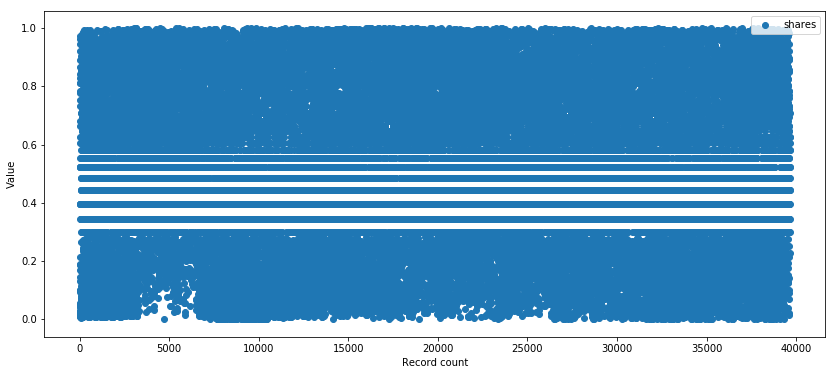

In [4]:
# Quick view of processed datasets
print('dataset {0}'.format(dataset.shape))
print('labels {0}'.format(labels.shape))
print('Labels max value: {0}'.format(np.max(labels)))
print('Labels min value: {0}'.format(np.min(labels)))
print('Labels avg value: {0}'.format(np.average(labels)))

def show_graph(data):
    plt.figure(figsize=(14,6))
    plt.xlabel("Record count")
    plt.ylabel("Value")
    plt.title("")
    x = list(range(len(data)))
    plt.scatter(x, [pt[0] for pt in data], label='shares')
    plt.legend(loc='upper right')
    plt.show()

def show_histogram(data):
    plt.figure(figsize=(14,6))
    plt.hist(data, 100)
    plt.show()

show_graph(labels)
# show_histogram(labels)

**Feature extraction**<br> 
To reduce number of features using MLP. MLP model will remain relativily simple to prevent over training. Model will output 20 nodes this will act as input for RBF model. 

**Reference**<br>
*kernel_regularizer*: Regularizer function applied to the kernel weights matrix (see regularizer).<br>
*activity_regularizer*: Regularizer function applied to the output of the layer (its "activation").

In [24]:
# build model
l2_kernal = 0.0001

model = Sequential()
model.add(Dense(128, input_dim=39, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(l2_kernal)))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001),
              metrics=['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               5120      
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                2580      
_________________________________________________________________
dropout_10 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 21        
Total params: 7,721
Trainable params: 7,721
Non-trainable params: 0
_________________________________________________________________


In [26]:
# training with callbacks
saved_weights_name = 'best_features_extraction_rbf.h5'

if os.path.isfile(saved_weights_name):
    model.load_weights(saved_weights_name)
    print("Weights loaded: {0}".format(saved_weights_name))

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001,
                           patience=8,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint(saved_weights_name,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=0.00001,
                              verbose=1)
    
history = model.fit(x_train, y_train,
                      epochs=50,
                      validation_data=(x_test, y_test),
                      callbacks=[early_stop, checkpoint, reduce_lr],
                      verbose=1)

Weights loaded: best_features_extraction_rbf.h5
Train on 31715 samples, validate on 7929 samples
Epoch 1/50
31715/31715 [==============================] - 3s 109us/step - loss: 0.0418 - mean_squared_error: 0.0327 - val_loss: 0.0262 - val_mean_squared_error: 0.0172

Epoch 00001: val_loss improved from inf to 0.02619, saving model to best_features_extraction_rbf.h5
Epoch 2/50
31715/31715 [==============================] - 3s 106us/step - loss: 0.0413 - mean_squared_error: 0.0323 - val_loss: 0.0265 - val_mean_squared_error: 0.0176

Epoch 00002: val_loss did not improve
Epoch 3/50
31715/31715 [==============================] - 3s 101us/step - loss: 0.0417 - mean_squared_error: 0.0326 - val_loss: 0.0263 - val_mean_squared_error: 0.0173

Epoch 00003: val_loss did not improve
Epoch 4/50
31715/31715 [==============================] - 3s 100us/step - loss: 0.0412 - mean_squared_error: 0.0322 - val_loss: 0.0261 - val_mean_squared_error: 0.0172

Epoch 00004: val_loss improved from 0.02619 to 0.02

**Freezing layers**<br>
Freezing all MLP layers to prevent MLP layers from training. Set model last layer as output layer, output 20 nodes.<br>
Take note that trainable params: 0

In [27]:
for layer in model.layers:
    layer.trainable = False
    
model.layers.pop()
model.outputs = [model.layers[-1].output]

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               5120      
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                2580      
_________________________________________________________________
dropout_10 (Dropout)         (None, 20)                0         
Total params: 7,700
Trainable params: 0
Non-trainable params: 7,700
_________________________________________________________________


**Adding RBF layer**<br>
Adding RBF layer as final layer, this layer input receive (x, 20).<br>
Take note that only RBF layer will be trainable.

In [28]:
# https://www.youtube.com/watch?v=1Cw45yNm6VA
# build model
# beta - controls the drop off of circle. higher the beta the faster the circle will drop off. This will then affect the 
#        size of the circle, faster drop off will cause new circle to form.
#        (Drop of refers of gradient of circle, how smooth transit from circle area to non-circle area)
# training with callbacks

rbflayer = RBFLayer(20,
                    betas=0.1,
                    input_shape=(20,))
model.add(rbflayer)
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001),
              metrics=['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               5120      
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                2580      
_________________________________________________________________
dropout_10 (Dropout)         (None, 20)                0         
_________________________________________________________________
rbf_layer_5 (RBFLayer)       (None, 20)                420       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 21        
Total params: 8,141
Trainable params: 441
Non-trainable params: 7,700
_________________________________________________________________


In [29]:
# training with callbacks
saved_weights_name = 'best_weights_rbf.h5'

if os.path.isfile(saved_weights_name):
    model.load_weights(saved_weights_name)
    print("Weights loaded: {0}".format(saved_weights_name))

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001,
                           patience=8,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint(saved_weights_name,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=0.00001,
                              verbose=1)
    
history = model.fit(x_train, y_train,
                      epochs=50,
                      validation_data=(x_test, y_test),
                      callbacks=[early_stop, checkpoint, reduce_lr],
                      verbose=1)

Train on 31715 samples, validate on 7929 samples
Epoch 1/50
31715/31715 [==============================] - 4s 114us/step - loss: 0.0883 - mean_squared_error: 0.0804 - val_loss: 0.0829 - val_mean_squared_error: 0.0749

Epoch 00001: val_loss improved from inf to 0.08288, saving model to best_weights_rbf.h5
Epoch 2/50
31715/31715 [==============================] - 3s 107us/step - loss: 0.0813 - mean_squared_error: 0.0734 - val_loss: 0.0744 - val_mean_squared_error: 0.0665

Epoch 00002: val_loss improved from 0.08288 to 0.07445, saving model to best_weights_rbf.h5
Epoch 3/50
31715/31715 [==============================] - 3s 108us/step - loss: 0.0742 - mean_squared_error: 0.0662 - val_loss: 0.0655 - val_mean_squared_error: 0.0576

Epoch 00003: val_loss improved from 0.07445 to 0.06553, saving model to best_weights_rbf.h5
Epoch 4/50
31715/31715 [==============================] - 4s 114us/step - loss: 0.0672 - mean_squared_error: 0.0593 - val_loss: 0.0593 - val_mean_squared_error: 0.0513

Epo

31715/31715 [==============================] - 3s 102us/step - loss: 0.0405 - mean_squared_error: 0.0325 - val_loss: 0.0250 - val_mean_squared_error: 0.0170

Epoch 00034: val_loss did not improve
Epoch 35/50
31715/31715 [==============================] - 3s 100us/step - loss: 0.0401 - mean_squared_error: 0.0322 - val_loss: 0.0238 - val_mean_squared_error: 0.0159

Epoch 00035: val_loss did not improve
Epoch 36/50
31715/31715 [==============================] - 3s 100us/step - loss: 0.0402 - mean_squared_error: 0.0323 - val_loss: 0.0230 - val_mean_squared_error: 0.0150

Epoch 00036: val_loss did not improve

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 37/50
31715/31715 [==============================] - 4s 114us/step - loss: 0.0401 - mean_squared_error: 0.0321 - val_loss: 0.0223 - val_mean_squared_error: 0.0143

Epoch 00037: val_loss did not improve
Epoch 38/50
31715/31715 [==============================] - 3s 100us/step - loss: 0.0395 - mean_squ

*** Recall our target is last element Shares *** <br>
Shares: Number of shares

7929/7929 [==============================] - 0s 50us/step
actual max 0.9992343966165429
actual min 6.387735547748322e-05
actual median 0.4444444444444444
predict max 0.9999998807907104
predict min 0.2631058096885681
predict median 0.4195704460144043

loss: 0.022356
mean_squared_error: 0.014396
root_mse: 0.119984
explained_variance_score: 0.762068
mean_absolute_error: 0.09119
mean_squared_log_error: 0.009118
median_absolute_error: 0.069093
r2_score: 0.72928


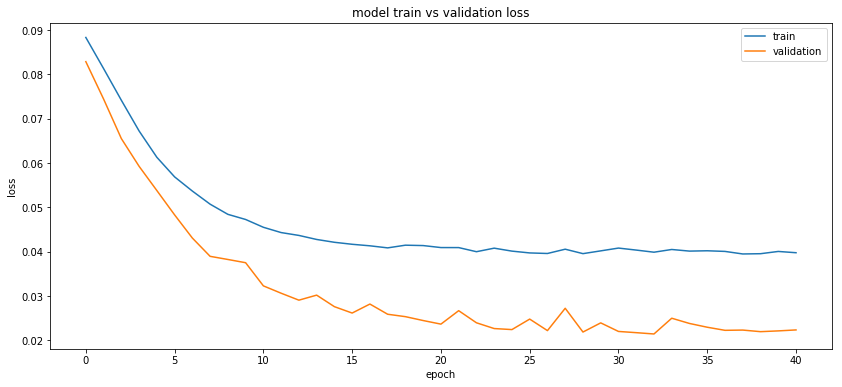

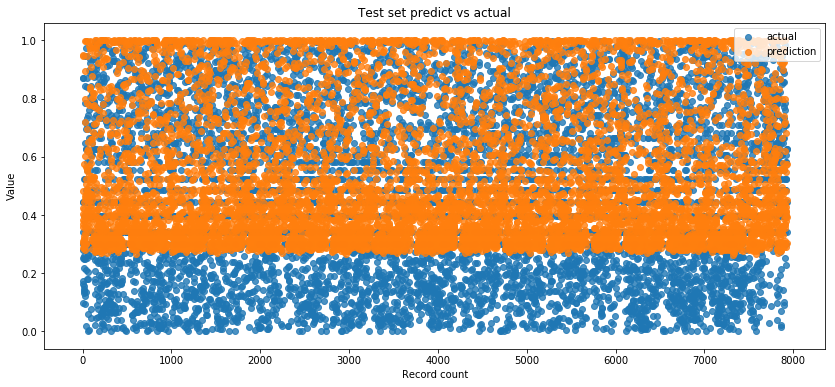

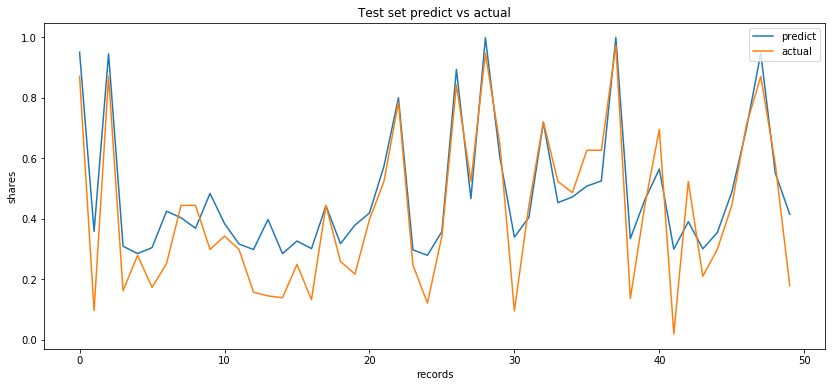

In [30]:
# showing results
scores = model.evaluate(x_test, y_test)

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
y_pred = model.predict(x_test)

root_mse = math.sqrt(scores[1])
var_score = explained_variance_score(y_pred, y_test)
mean_abs_error = mean_absolute_error(y_pred, y_test)
mean_sqare_log_error = mean_squared_log_error(y_pred, y_test)
median_abs_error = median_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print('actual max {0}'.format(np.max(y_test)))
print('actual min {0}'.format(np.min(y_test)))
print('actual median {0}'.format(np.median(y_test)))
print('predict max {0}'.format(np.max(y_pred)))
print('predict min {0}'.format(np.min(y_pred)))
print('predict median {0}'.format(np.median(y_pred)))
print()
print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
print('root_mse: {0}'.format(round(root_mse, 6)))
print('explained_variance_score: {0}'.format(round(var_score, 6)))
print('mean_absolute_error: {0}'.format(round(mean_abs_error, 6)))
print('mean_squared_log_error: {0}'.format(round(mean_sqare_log_error, 6)))
print('median_absolute_error: {0}'.format(round(median_abs_error, 6)))
print('r2_score: {0}'.format(round(r2, 6)))

# plt.figure(figsize=(14,6))
# plt.hist(y_pred, 100)
# plt.hist(y_test, 100)
# plt.show()

plt.figure(figsize=(14,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.xlabel("Record count")
plt.ylabel("Value")
plt.title("Test set predict vs actual")
x = list(range(len(y_pred)))
# plt.ylim(0, 1)
plt.scatter(x, [pt[0] for pt in y_test], label='actual', alpha=0.8)
plt.scatter(x, [pt[0] for pt in y_pred], label='prediction', alpha=0.8)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.title('Test set predict vs actual')
plt.plot(y_pred[:50])
plt.plot(y_test[:50])
plt.ylabel('shares')
plt.xlabel('records')
plt.legend(['predict', 'actual'], loc='upper right', borderaxespad=0.5)
plt.show()

In [3]:
# kfold on dataset and training
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

# kfold setup
l2_kernal = 0.0001
kfold_result = []
kf = KFold(n_splits=5, shuffle=True, random_state=100)
for train_index, test_index in kf.split(dataset):
    x_train, x_test = dataset[train_index], dataset[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
#     print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
#     print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))
    
    # load pretrained MLP weights
    model = Sequential()
    model.add(Dense(128, input_dim=39, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(l2_kernal)))

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=0.001),
                  metrics=['mse'])

    saved_weights_name = 'best_features_extraction_rbf.h5'
    if os.path.isfile(saved_weights_name):
        model.load_weights(saved_weights_name)
        print("Weights loaded: {0}".format(saved_weights_name))

    # modify extraction network final layer
    for layer in model.layers:
        layer.trainable = False

    model.layers.pop()
    model.outputs = [model.layers[-1].output]
    
    # Add RBL layer to model
    rbflayer = RBFLayer(20,
                        betas=0.1,
                        input_shape=(20,))
    model.add(rbflayer)
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=0.001),
                  metrics=['mse'])
    
    # train model
    early_stop = EarlyStopping(monitor='val_loss',
                               min_delta=0.0001,
                               patience=6,
                               mode='min',
                               verbose=1)

    checkpoint = ModelCheckpoint(saved_weights_name,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',
                                 period=1)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.2,
                                  patience=2,
                                  min_lr=0.00001,
                                  verbose=1)

    history = model.fit(x_train, y_train,
                          epochs=50,
                          validation_data=(x_test, y_test),
                          callbacks=[early_stop, reduce_lr],
                          verbose=1)
    
    # evaluating model
    scores = model.evaluate(x_test, y_test)
    print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
    print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
    y_pred = model.predict(x_test)    
    r2 = r2_score(y_pred, y_test)
    root_mse = math.sqrt(scores[1])    
    print('r2_score: {0}'.format(round(r2, 6)))
    print('rmse: {0}'.format(round(root_mse, 6)))
    kfold_result.append([scores[0], scores[1], r2, root_mse])

Original dataset shape: (39644, 60), Labels: (39644, 1)
Data is normalize
Outlier removed: 0
Dataset shape: (39644, 39), Labels: (39644, 1)
Weights loaded: best_features_extraction_rbf.h5
Train on 31715 samples, validate on 7929 samples
Epoch 1/50
31715/31715 [==============================] - 3s 96us/step - loss: 0.0881 - mean_squared_error: 0.0801 - val_loss: 0.0835 - val_mean_squared_error: 0.0755
Epoch 2/50
31715/31715 [==============================] - 3s 92us/step - loss: 0.0806 - mean_squared_error: 0.0726 - val_loss: 0.0743 - val_mean_squared_error: 0.0663
Epoch 3/50
31715/31715 [==============================] - 3s 89us/step - loss: 0.0726 - mean_squared_error: 0.0646 - val_loss: 0.0648 - val_mean_squared_error: 0.0568
Epoch 4/50
31715/31715 [==============================] - 3s 91us/step - loss: 0.0650 - mean_squared_error: 0.0570 - val_loss: 0.0567 - val_mean_squared_error: 0.0487
Epoch 5/50
31715/31715 [==============================] - 3s 88us/step - loss: 0.0593 - mean_sq

31715/31715 [==============================] - 3s 86us/step - loss: 0.0715 - mean_squared_error: 0.0635 - val_loss: 0.0626 - val_mean_squared_error: 0.0546
Epoch 4/50
31715/31715 [==============================] - 3s 90us/step - loss: 0.0643 - mean_squared_error: 0.0563 - val_loss: 0.0549 - val_mean_squared_error: 0.0469
Epoch 5/50
31715/31715 [==============================] - 3s 86us/step - loss: 0.0589 - mean_squared_error: 0.0509 - val_loss: 0.0483 - val_mean_squared_error: 0.0403
Epoch 6/50
31715/31715 [==============================] - 3s 92us/step - loss: 0.0543 - mean_squared_error: 0.0463 - val_loss: 0.0446 - val_mean_squared_error: 0.0366
Epoch 7/50
31715/31715 [==============================] - 3s 89us/step - loss: 0.0516 - mean_squared_error: 0.0436 - val_loss: 0.0395 - val_mean_squared_error: 0.0315
Epoch 8/50
31715/31715 [==============================] - 3s 91us/step - loss: 0.0489 - mean_squared_error: 0.0409 - val_loss: 0.0359 - val_mean_squared_error: 0.0279
Epoch 9/5

Epoch 23/50
31715/31715 [==============================] - 3s 100us/step - loss: 0.0399 - mean_squared_error: 0.0320 - val_loss: 0.0225 - val_mean_squared_error: 0.0145
Epoch 24/50
31715/31715 [==============================] - 3s 92us/step - loss: 0.0400 - mean_squared_error: 0.0320 - val_loss: 0.0232 - val_mean_squared_error: 0.0152
Epoch 25/50
31715/31715 [==============================] - 3s 90us/step - loss: 0.0402 - mean_squared_error: 0.0322 - val_loss: 0.0235 - val_mean_squared_error: 0.0155
Epoch 26/50
31715/31715 [==============================] - 3s 94us/step - loss: 0.0396 - mean_squared_error: 0.0316 - val_loss: 0.0238 - val_mean_squared_error: 0.0158

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 27/50
31715/31715 [==============================] - 3s 97us/step - loss: 0.0399 - mean_squared_error: 0.0319 - val_loss: 0.0231 - val_mean_squared_error: 0.0151
Epoch 28/50
31715/31715 [==============================] - 3s 101us/step - lo

Epoch 26/50
31715/31715 [==============================] - 3s 90us/step - loss: 0.0396 - mean_squared_error: 0.0316 - val_loss: 0.0223 - val_mean_squared_error: 0.0143

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 27/50
31715/31715 [==============================] - 3s 90us/step - loss: 0.0400 - mean_squared_error: 0.0320 - val_loss: 0.0218 - val_mean_squared_error: 0.0138
Epoch 28/50
31715/31715 [==============================] - 3s 89us/step - loss: 0.0391 - mean_squared_error: 0.0311 - val_loss: 0.0214 - val_mean_squared_error: 0.0134
Epoch 29/50
31715/31715 [==============================] - 3s 93us/step - loss: 0.0399 - mean_squared_error: 0.0319 - val_loss: 0.0215 - val_mean_squared_error: 0.0135
Epoch 30/50
31715/31715 [==============================] - 3s 100us/step - loss: 0.0398 - mean_squared_error: 0.0318 - val_loss: 0.0216 - val_mean_squared_error: 0.0136
Epoch 31/50
31715/31715 [==============================] - 3s 97us/step - los

In [4]:
avg_loss = 0
avg_mse = 0
avg_r2 = 0
avg_root_mse = 0

for idx, scores in enumerate(kfold_result):
    avg_loss += scores[0]
    avg_mse += scores[1]
    avg_r2 += scores[2]
    avg_root_mse += scores[3]
    print('kfold {0}'.format(idx+1))
    print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
    print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
    print('r2_score: {0}'.format(round(scores[2], 6)))
    print('rmse: {0}'.format(round(scores[3], 6)))
    print()

print('kfold loss: {0}'.format(round(avg_loss, 6)))
print('kfold mse: {0}'.format(round(avg_mse, 6)))
print('kfold r2: {0}'.format(round((avg_r2/5), 6)))
print('kfold rmse: {0}'.format(round((avg_root_mse/5), 6)))

kfold 1
loss: 0.021385
mean_squared_error: 0.013388
r2_score: 0.768324
rmse: 0.115707

kfold 2
loss: 0.023381
mean_squared_error: 0.015385
r2_score: 0.702105
rmse: 0.124035

kfold 3
loss: 0.02194
mean_squared_error: 0.013943
r2_score: 0.755772
rmse: 0.118082

kfold 4
loss: 0.021797
mean_squared_error: 0.0138
r2_score: 0.751199
rmse: 0.117472

kfold 5
loss: 0.021072
mean_squared_error: 0.013075
r2_score: 0.775595
rmse: 0.114346

kfold loss: 0.109575
kfold mse: 0.069591
kfold r2: 0.750599
kfold rmse: 0.117929


#### Learing curve 
This graph provide a overview to determine if model is over-fiting or under-fitting due to changes in size of dataset

In [17]:
# load pretrained MLP weights
model = Sequential()
model.add(Dense(128, input_dim=39, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(l2_kernal)))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001),
              metrics=['mse'])

saved_weights_name = 'best_features_extraction_rbf.h5'
if os.path.isfile(saved_weights_name):
    model.load_weights(saved_weights_name)
    print("Weights loaded: {0}".format(saved_weights_name))

# modify extraction network final layer
for layer in model.layers:
    layer.trainable = False

model.layers.pop()
model.outputs = [model.layers[-1].output]

# Add RBL layer to model
rbflayer = RBFLayer(20,
                    betas=0.1,
                    input_shape=(20,))
model.add(rbflayer)
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001),
              metrics=['mse'])

# training with callbacks
saved_weights_name = 'best_weights_rbf.h5'

if os.path.isfile(saved_weights_name):
    model.load_weights(saved_weights_name)
    print("Weights loaded: {0}".format(saved_weights_name))
    
# kfold on dataset and training
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=False, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

histories = []
for i in range(1, 11):
    sub_x_train = x_train[0: int(len(x_train) * (i / 10))]
    sub_y_train = y_train[0: int(len(y_train) * (i / 10))]
    
    # train model
    early_stop = EarlyStopping(monitor='val_loss',
                               min_delta=0.0001,
                               patience=6,
                               mode='min',
                               verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.2,
                                  patience=2,
                                  min_lr=0.00001,
                                  verbose=1)

    history = model.fit(sub_x_train, sub_y_train,
                          epochs=50,
                          validation_data=(x_test, y_test),
                          callbacks=[early_stop, reduce_lr],
                          verbose=1)
    
    histories.append(history)

Weights loaded: best_features_extraction_rbf.h5
Weights loaded: best_weights_rbf.h5
Original dataset shape: (39644, 60), Labels: (39644, 1)
Data is normalize
Outlier removed: 0
Dataset shape: (39644, 39), Labels: (39644, 1)
x_train: (31715, 39), y_train: (31715, 1)
x_test: (7929, 39), y_test: (7929, 1)
Train on 3171 samples, validate on 7929 samples
Epoch 1/50
3171/3171 [==============================] - 1s 267us/step - loss: 0.0456 - mean_squared_error: 0.0376 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 2/50
3171/3171 [==============================] - 0s 155us/step - loss: 0.0425 - mean_squared_error: 0.0345 - val_loss: 0.0214 - val_mean_squared_error: 0.0135
Epoch 3/50
3171/3171 [==============================] - 1s 160us/step - loss: 0.0442 - mean_squared_error: 0.0362 - val_loss: 0.0217 - val_mean_squared_error: 0.0138
Epoch 4/50
3171/3171 [==============================] - 0s 155us/step - loss: 0.0433 - mean_squared_error: 0.0354 - val_loss: 0.0244 - val_mean_square

19029/19029 [==============================] - 2s 118us/step - loss: 0.0420 - mean_squared_error: 0.0341 - val_loss: 0.0221 - val_mean_squared_error: 0.0141
Epoch 4/50
19029/19029 [==============================] - 2s 113us/step - loss: 0.0414 - mean_squared_error: 0.0334 - val_loss: 0.0219 - val_mean_squared_error: 0.0140
Epoch 5/50
19029/19029 [==============================] - 2s 119us/step - loss: 0.0411 - mean_squared_error: 0.0331 - val_loss: 0.0220 - val_mean_squared_error: 0.0140
Epoch 6/50
19029/19029 [==============================] - 2s 110us/step - loss: 0.0416 - mean_squared_error: 0.0336 - val_loss: 0.0219 - val_mean_squared_error: 0.0139
Epoch 7/50
19029/19029 [==============================] - 2s 110us/step - loss: 0.0414 - mean_squared_error: 0.0335 - val_loss: 0.0220 - val_mean_squared_error: 0.0140
Epoch 8/50
19029/19029 [==============================] - 2s 114us/step - loss: 0.0410 - mean_squared_error: 0.0331 - val_loss: 0.0218 - val_mean_squared_error: 0.0139
Epo

Epoch 8/50
31715/31715 [==============================] - 3s 106us/step - loss: 0.0399 - mean_squared_error: 0.0319 - val_loss: 0.0223 - val_mean_squared_error: 0.0143
Epoch 9/50
31715/31715 [==============================] - 3s 102us/step - loss: 0.0397 - mean_squared_error: 0.0317 - val_loss: 0.0222 - val_mean_squared_error: 0.0142
Epoch 10/50
31715/31715 [==============================] - 3s 106us/step - loss: 0.0398 - mean_squared_error: 0.0318 - val_loss: 0.0222 - val_mean_squared_error: 0.0142
Epoch 00010: early stopping


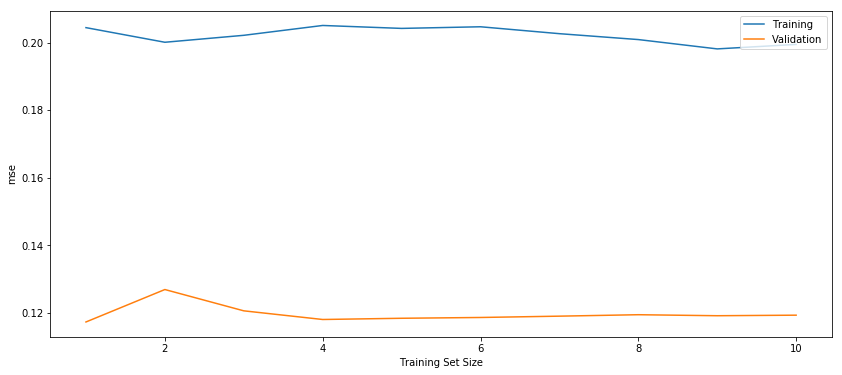

In [60]:
size_percentage = list(range(1, 11))
histories_loss = []
histories_mse = []
for h in histories:
    histories_loss.append(math.sqrt(h.history['loss'][-1]))
    histories_mse.append(math.sqrt(h.history['val_mean_squared_error'][-1]))
    
plt.figure(figsize=(14,6))
plt.plot(size_percentage, histories_loss, label='loss score')
plt.plot(size_percentage, histories_mse, label='validation score')
plt.xlabel('Training Set Size')
plt.ylabel('mse')
plt.legend(['Training', 'Validation'], loc='upper right')